In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, Descriptors,rdFingerprintGenerator
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

1、Load the training set and testing set

In [2]:
train_data=pd.read_csv(r"C:\Users\32258\Documents\Tencent Files\3225849325\FileRecv\pKa预测任务\pKa预测任务\Opt1_acidic_tr_CMF.csv")
test_data=pd.read_csv(r"C:\Users\32258\Documents\Tencent Files\3225849325\FileRecv\pKa预测任务\pKa预测任务\Opt1_acidic_tst_CMF.csv")

In [3]:
train_data.head()

,smiles,pKa
0,S(=O)(=O)(O)C1(=CC=C([N+](=O)[O-])C=C1),-7.15
1,S(=O)(=O)(O)C1(=CC([N+](=O)[O-])=CC=C1),-7.10
2,S(=O)(=O)(O)C1(=CC(=CC=C1)C(F)(F)F),-6.93
3,[Br]C1(=CC=C(S(=O)(=O)O)C=C1),-6.72
4,SC1(=[N+](C=CC=2(C1=CC=CC=2))C),-2.13


In [4]:
test_data.head()

,smiles,pKa
0,S(=O)(=O)(O)C1(=CC(=CC=C1)C),-6.56
1,SC1(=[NH+]C=CC=2(C1=CC=CC=2)),-1.90
2,OC1(=[NH+]C=2(C=CC=CC=2(N1))),-1.70
3,OC2(=[NH+]C=1(C(=CC=CC=1)N=C2)),-1.37
4,[Br]C1(=C(O)[NH+]=C([O-])[N+](=C1)C2(OC(CO)C(C...,-0.90


In [5]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2220 entries, 0 to 2219
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   smiles  2220 non-null   object 
 1   pKa     2220 non-null   float64
dtypes: float64(1), object(1)
memory usage: 34.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   smiles  740 non-null    object 
 1   pKa     740 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.7+ KB


In [6]:
# Check if there is None in our dataset 
missing_values = train_data.isnull().sum()
print(missing_values)
missing_values = test_data.isnull().sum()
print(missing_values)

smiles    0
pKa       0
dtype: int64
smiles    0
pKa       0
dtype: int64


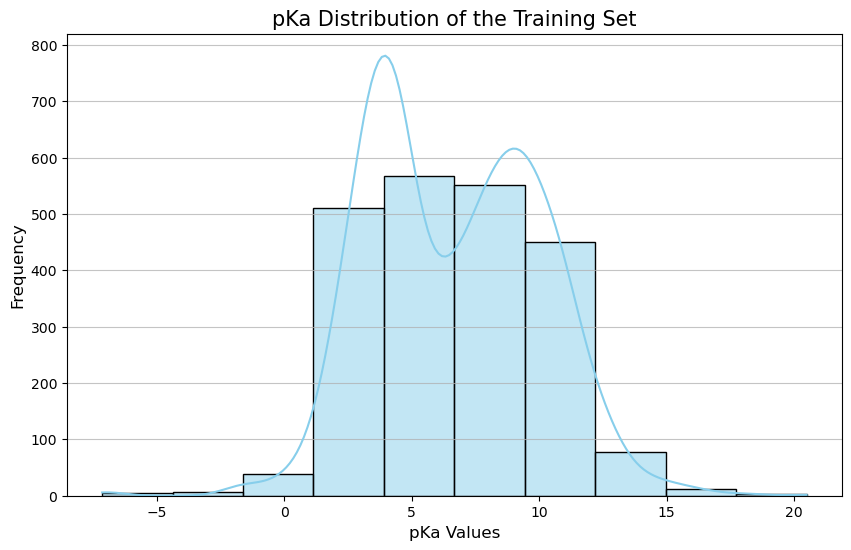

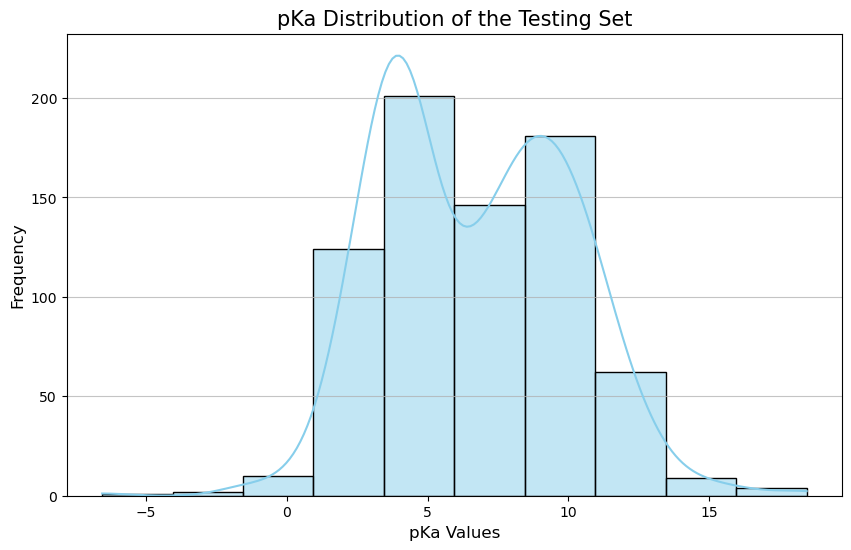

In [7]:
# Visualize the pKa distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_data["pKa"], bins=10, kde=True, color='skyblue')
plt.title('pKa Distribution of the Training Set', fontsize=15)
plt.xlabel('pKa Values', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(test_data["pKa"], bins=10, kde=True, color='skyblue')
plt.title('pKa Distribution of the Testing Set', fontsize=15)
plt.xlabel('pKa Values', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

2、Data Preprocessing

In [8]:
# Add molecule objects column
PandasTools.AddMoleculeColumnToFrame(train_data, smilesCol='smiles')
PandasTools.AddMoleculeColumnToFrame(test_data, smilesCol='smiles')

# Initialize storage columns
train_data['MorganFP'] = None  # For Morgan fingerprints (count vector)
test_data['MorganFP'] = None  
train_data['MACCSKeys'] = None  # For MACCS keys
test_data['MACCSKeys'] = None  
train_data['RDKitDescriptors'] = None  # For descriptor dictionaries
test_data['RDKitDescriptors'] = None  

# Initialize the Morgan fingerprint generator for count vector

for idx, row in train_data.iterrows():
    mol = row['ROMol']
    if mol is None:
        continue
    
    # Generate Morgan fingerprint as count vector 
    train_data.at[idx, 'MorganFP'] = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    
    # Generate MACCS keys
    train_data.at[idx, 'MACCSKeys'] = MACCSkeys.GenMACCSKeys(mol)
    
    # Calculate RDKit descriptors
    train_data.at[idx, 'RDKitDescriptors'] = Descriptors.CalcMolDescriptors(mol)

# Calculate molecular features for test data
for idx, row in test_data.iterrows():
    mol = row['ROMol']
    if mol is None:
        continue
    
    # Generate Morgan fingerprint as count vector
    test_data.at[idx, 'MorganFP'] = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    
    # Generate MACCS keys
    test_data.at[idx, 'MACCSKeys'] = MACCSkeys.GenMACCSKeys(mol)
    
    # Calculate RDKit descriptors
    test_data.at[idx, 'RDKitDescriptors'] = Descriptors.CalcMolDescriptors(mol)


[10:40:23] DEPRECATION WARNING: please use MorganGenerator
[10:40:23] DEPRECATION WARNING: please use MorganGenerator
[10:40:23] DEPRECATION WARNING: please use MorganGenerator
[10:40:23] DEPRECATION WARNING: please use MorganGenerator
[10:40:23] DEPRECATION WARNING: please use MorganGenerator
[10:40:23] DEPRECATION WARNING: please use MorganGenerator
[10:40:23] DEPRECATION WARNING: please use MorganGenerator
[10:40:23] DEPRECATION WARNING: please use MorganGenerator
[10:40:23] DEPRECATION WARNING: please use MorganGenerator
[10:40:23] DEPRECATION WARNING: please use MorganGenerator
[10:40:23] DEPRECATION WARNING: please use MorganGenerator
[10:40:23] DEPRECATION WARNING: please use MorganGenerator
[10:40:23] DEPRECATION WARNING: please use MorganGenerator
[10:40:23] DEPRECATION WARNING: please use MorganGenerator
[10:40:23] DEPRECATION WARNING: please use MorganGenerator
[10:40:23] DEPRECATION WARNING: please use MorganGenerator
[10:40:23] DEPRECATION WARNING: please use MorganGenerat

In [9]:
# Extract the length of three descriptors
# MorganFP
print("The length of MorganFP is:", len(train_data['MorganFP'].iloc[0]))
# MACCSKeys
print("The length of MACCSKeys is:", len(train_data['MACCSKeys'].iloc[0]))
# RDKit Descriptor
descriptor_names = [desc[0] for desc in Descriptors.descList]
print("The length of RDKit descriptors is:",len(descriptor_names))
print(descriptor_names)

The length of MorganFP is: 2048
The length of MACCSKeys is: 167
The length of RDKit descriptors is: 210
['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3',

In [10]:
train_data.head()

,smiles,pKa,ROMol,MorganFP,MACCSKeys,RDKitDescriptors
0,S(=O)(=O)(O)C1(=CC=C([N+](=O)[O-])C=C1),-7.15,<rdkit.Chem.rdchem.Mol object at 0x0000020C5A0...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'MaxAbsEStateIndex': 10.499726001511716, 'Max..."
1,S(=O)(=O)(O)C1(=CC([N+](=O)[O-])=CC=C1),-7.10,<rdkit.Chem.rdchem.Mol object at 0x0000020C5A0...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'MaxAbsEStateIndex': 10.540648148148149, 'Max..."
2,S(=O)(=O)(O)C1(=CC(=CC=C1)C(F)(F)F),-6.93,<rdkit.Chem.rdchem.Mol object at 0x0000020C5A0...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'MaxAbsEStateIndex': 12.079595616024188, 'Max..."
3,[Br]C1(=CC=C(S(=O)(=O)O)C=C1),-6.72,<rdkit.Chem.rdchem.Mol object at 0x0000020C5A0...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'MaxAbsEStateIndex': 10.484419879062736, 'Max..."
4,SC1(=[N+](C=CC=2(C1=CC=CC=2))C),-2.13,<rdkit.Chem.rdchem.Mol object at 0x0000020C5A0...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'MaxAbsEStateIndex': 4.42675925925926, 'MaxES..."


In [11]:
test_data.head()

,smiles,pKa,ROMol,MorganFP,MACCSKeys,RDKitDescriptors
0,S(=O)(=O)(O)C1(=CC(=CC=C1)C),-6.56,<rdkit.Chem.rdchem.Mol object at 0x0000020C5A0...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'MaxAbsEStateIndex': 10.540648148148149, 'Max..."
1,SC1(=[NH+]C=CC=2(C1=CC=CC=2)),-1.90,<rdkit.Chem.rdchem.Mol object at 0x0000020C5BA...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'MaxAbsEStateIndex': 4.294814814814815, 'MaxE..."
2,OC1(=[NH+]C=2(C=CC=CC=2(N1))),-1.70,<rdkit.Chem.rdchem.Mol object at 0x0000020C5BA...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'MaxAbsEStateIndex': 8.945, 'MaxEStateIndex':..."
3,OC2(=[NH+]C=1(C(=CC=CC=1)N=C2)),-1.37,<rdkit.Chem.rdchem.Mol object at 0x0000020C5BA...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'MaxAbsEStateIndex': 9.01218820861678, 'MaxES..."
4,[Br]C1(=C(O)[NH+]=C([O-])[N+](=C1)C2(OC(CO)C(C...,-0.90,<rdkit.Chem.rdchem.Mol object at 0x0000020C5BA...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'MaxAbsEStateIndex': 11.617815098261527, 'Max..."


In [12]:
X_train_morgan = np.stack(train_data['MorganFP'].apply(lambda x: np.array(x, dtype=np.float32)))
X_train_maccs = np.stack(train_data['MACCSKeys'].apply(lambda x: np.array(x, dtype=np.float32)))
X_test_morgan = np.stack(test_data['MorganFP'].apply(lambda x: np.array(x, dtype=np.float32)))
X_test_maccs = np.stack(test_data['MACCSKeys'].apply(lambda x: np.array(x, dtype=np.float32)))
all_descriptors = set()
for desc_dict in train_data['RDKitDescriptors']:
    all_descriptors.update(desc_dict.keys())
all_descriptors = sorted(list(all_descriptors))

def convert_rdkit_desc(desc_dict):
    return [desc_dict.get(key, np.nan) for key in all_descriptors]

X_train_rdkit = np.array([convert_rdkit_desc(d) for d in train_data['RDKitDescriptors']])
X_test_rdkit = np.array([convert_rdkit_desc(d) for d in test_data['RDKitDescriptors']])

# Fill the NaN with the mean value
imputer = SimpleImputer(strategy='mean')
X_train_rdkit = imputer.fit_transform(X_train_rdkit)
X_test_rdkit = imputer.fit_transform(X_test_rdkit)

y_train = train_data['pKa'].values
y_test = test_data['pKa'].values

scaler = StandardScaler()
X_scaled_train_rdkit = scaler.fit_transform(X_train_rdkit)
X_scaled_test_rdkit = scaler.fit_transform(X_test_rdkit)

3、Multiple Model Training

In [13]:
# The models we want to compare
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector": SVR(),
    "KNN": KNeighborsRegressor()
}

# The features to input
features = {
    "MorganFP": X_train_morgan,
    "MACCSKeys": X_train_maccs,
    "RDKitDescriptors": X_train_rdkit,
    "ScaledRDKitDescriptors": X_scaled_train_rdkit
}

results = []

# Run all models and features
for model_name, model in models.items():
    for feat_name, X in features.items():
        # Train model
        model.fit(X, y_train)
        y_pred = model.predict(X)
        r2 = r2_score(y_train, y_pred)
        rmse = np.sqrt(mean_squared_error(y_train, y_pred))
        results.append({
            "Model": model_name,
            "Feature": feat_name,
            "R2": r2,
            "RMSE": rmse
        })

results_df = pd.DataFrame(results)

d:\anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.55195e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


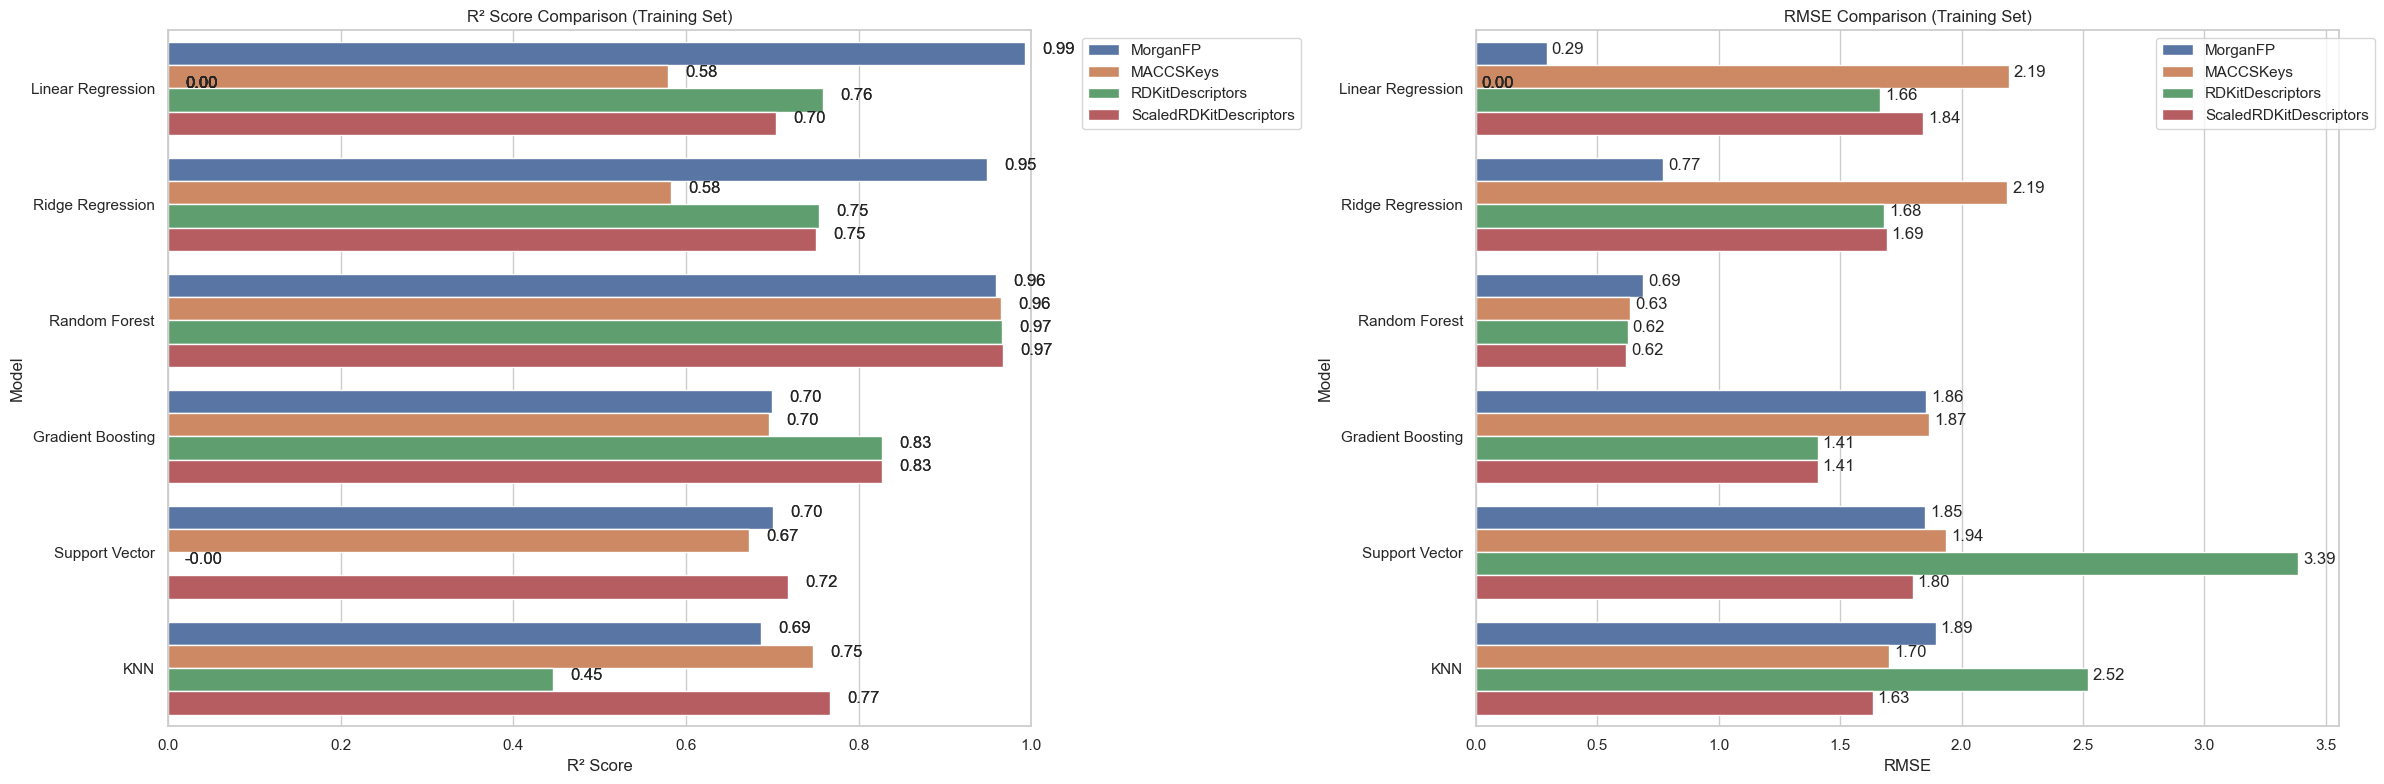

In [14]:
plt.figure(figsize=(24, 8))
sns.set_theme(style="whitegrid")

# R2
plt.subplot(1, 2, 1)
sns.barplot(data=results_df, x="R2", y="Model", hue="Feature", orient="h")
plt.title("R² Score Comparison (Training Set)")
plt.xlabel("R² Score")
plt.xlim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1))
for ax in plt.gcf().axes:
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 0.02, p.get_y() + p.get_height()/2, f'{width:.2f}', ha='left')

# RMSE
plt.subplot(1, 2, 2)
sns.barplot(data=results_df, x="RMSE", y="Model", hue="Feature", orient="h")
plt.title("RMSE Comparison (Training Set)")
plt.xlabel("RMSE")
plt.legend(bbox_to_anchor=(1.05, 1))
for ax in plt.gcf().axes:
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 0.02, p.get_y() + p.get_height()/2, f'{width:.2f}', ha='left')

plt.tight_layout()
plt.show()

4、Further Adjustment with RandomForest

In [15]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Define the evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    return {
        "Train R2": r2_score(y_train, y_pred_train),
        "Train RMSE": np.sqrt(mean_squared_error(y_train, y_pred_train)),
        "Test R2": r2_score(y_test, y_pred_test),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_pred_test))
    }

features = {
    "Morgan": X_train_morgan,
    "MACCS": X_train_maccs,
    "RDKit": X_train_rdkit,
    "ScaledRDKitDescriptors": X_scaled_train_rdkit
}

results = []
best_models = {}

for feat_name, X_train in features.items():
    print(f"\n=== Processing: {feat_name} ===")
    
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        verbose=0,
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_models[feat_name] = best_model
    
    if feat_name == "ScaledRDKitDescriptors":
        X_test = X_scaled_test_rdkit  
    else:
        X_test = eval(f"X_test_{feat_name.lower()}")  
    
    metrics = evaluate_model(best_model, X_train, y_train, X_test, y_test)
    results.append({
        "Feature": feat_name,
        "Best Params": grid_search.best_params_,
        **metrics
    })

results_df = pd.DataFrame(results)


=== Processing: Morgan ===

=== Processing: MACCS ===

=== Processing: RDKit ===

=== Processing: ScaledRDKitDescriptors ===


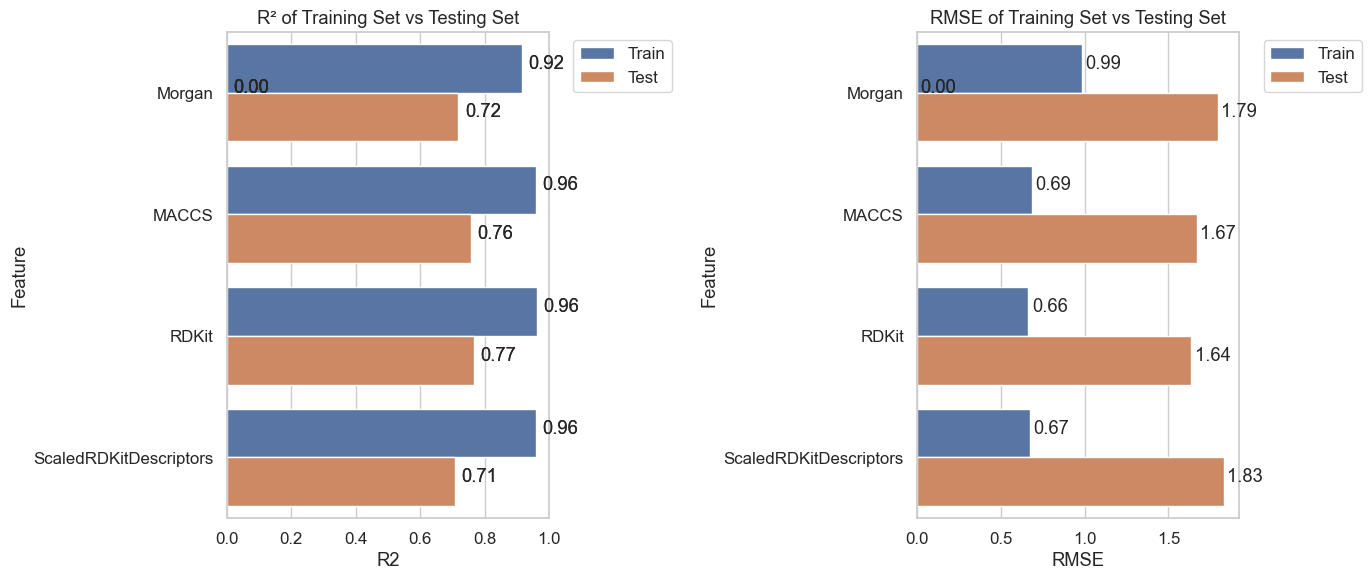

In [16]:
r2_df = results_df.melt(
    id_vars="Feature", 
    value_vars=["Train R2", "Test R2"],
    var_name="Dataset", 
    value_name="R2"
)
r2_df["Dataset"] = r2_df["Dataset"].str.replace(" R2", "") 

rmse_df = results_df.melt(
    id_vars="Feature", 
    value_vars=["Train RMSE", "Test RMSE"],
    var_name="Dataset", 
    value_name="RMSE"
)
rmse_df["Dataset"] = rmse_df["Dataset"].str.replace(" RMSE", "")


plt.figure(figsize=(14, 6))
sns.set_theme(style="whitegrid", font_scale=1.1)

# R² 
plt.subplot(1, 2, 1)
sns.barplot(
    data=r2_df,
    x="R2", 
    y="Feature", 
    hue="Dataset",
    palette={"Train": "#4C72B0", "Test": "#DD8452"},  
    dodge=True  
)
plt.title("R² of Training Set vs Testing Set")
plt.xlim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  
for ax in plt.gcf().axes:
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 0.02, p.get_y() + p.get_height()/2, f'{width:.2f}', ha='left')

# RMSE 
plt.subplot(1, 2, 2)
sns.barplot(
    data=rmse_df,
    x="RMSE", 
    y="Feature", 
    hue="Dataset",
    palette={"Train": "#4C72B0", "Test": "#DD8452"},
    dodge=True
)
plt.title("RMSE of Training Set vs Testing Set")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
for ax in plt.gcf().axes:
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 0.02, p.get_y() + p.get_height()/2, f'{width:.2f}', ha='left')

plt.tight_layout()
plt.show()

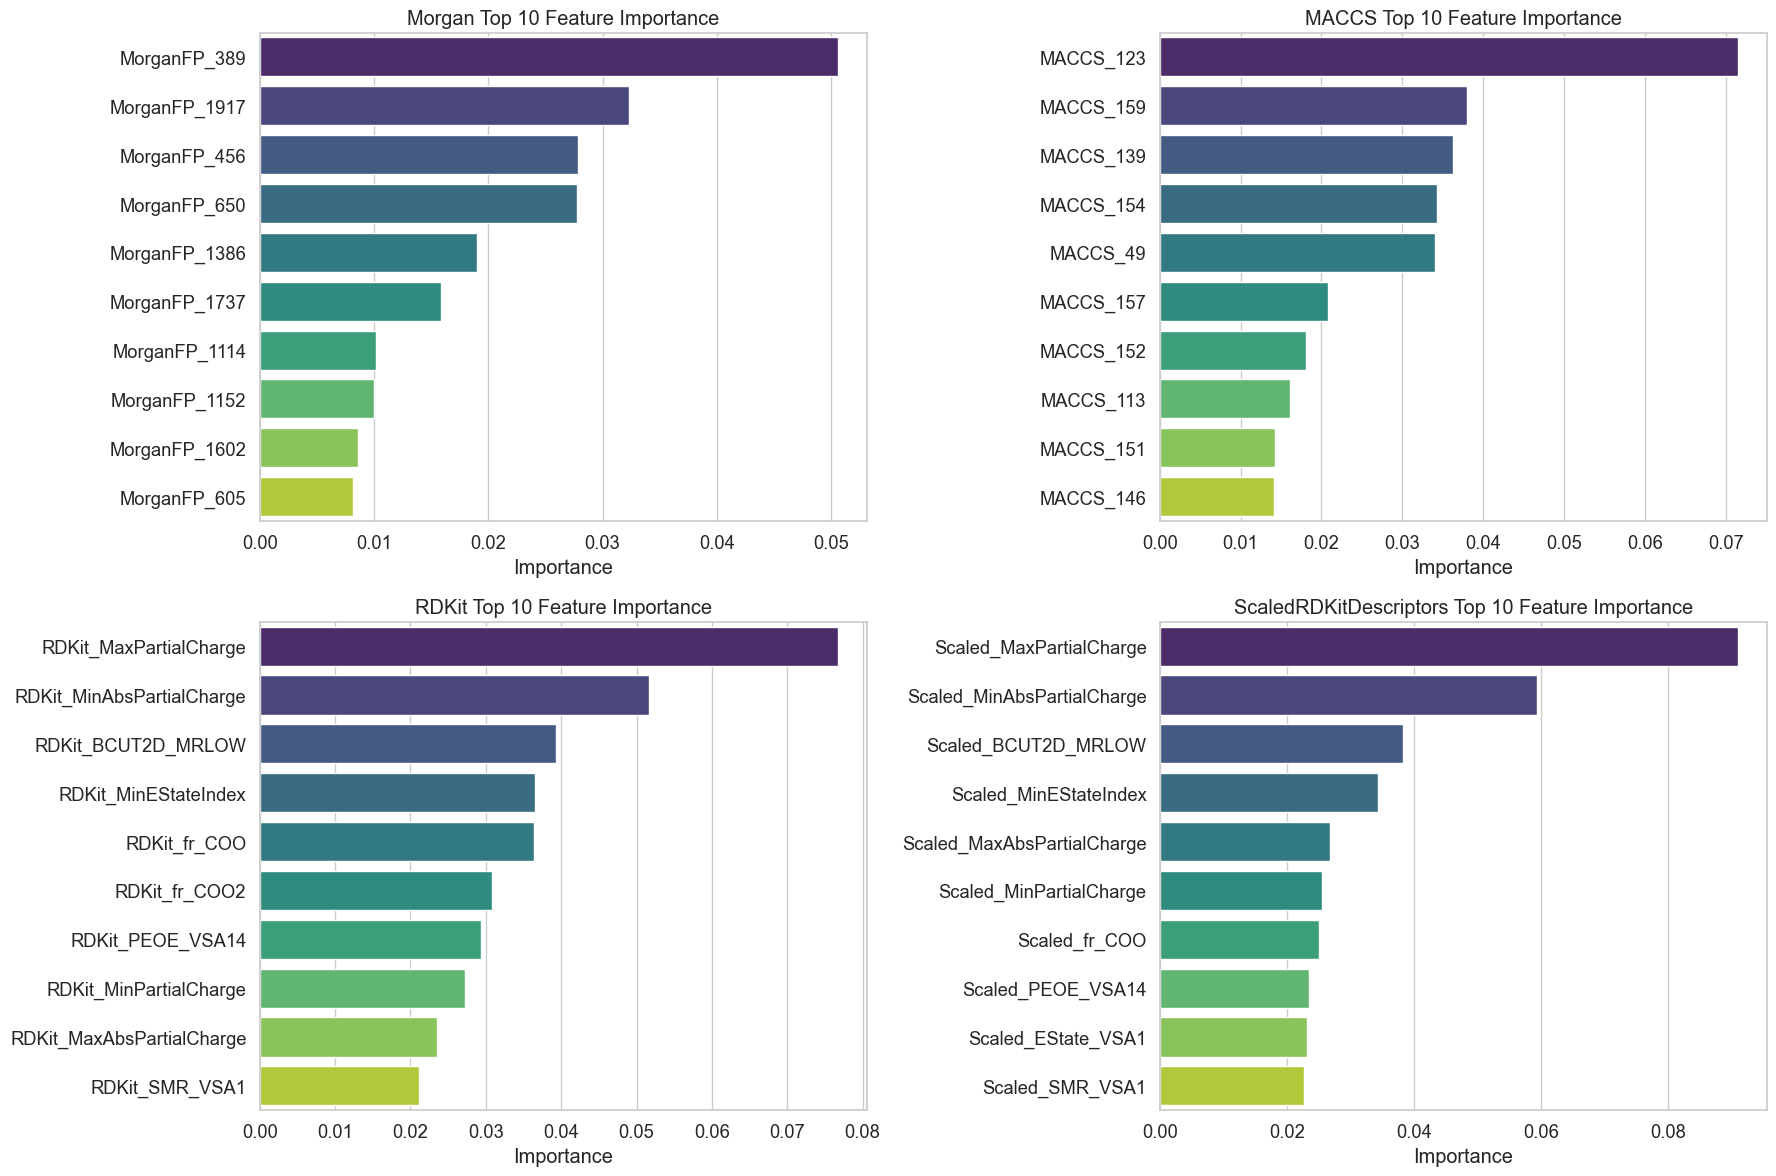

In [17]:
def get_feature_names(feat_name):
    if feat_name == "Morgan":
        return [f"MorganFP_{i}" for i in range(X_train_morgan.shape[1])]
    elif feat_name == "MACCS":
        return [f"MACCS_{i}" for i in range(X_train_maccs.shape[1])]
    elif feat_name == "RDKit":
        return [f"RDKit_{desc}" for desc in all_descriptors]
    elif feat_name == "ScaledRDKitDescriptors":
        return [f"Scaled_{desc}" for desc in all_descriptors]

# Extract the top 10 features
importance_dfs = {}
for feat_name, model in best_models.items():
    importances = model.feature_importances_
    feat_names = get_feature_names(feat_name)
    df = pd.DataFrame({
        "Feature": feat_names,
        "Importance": importances
    }).sort_values("Importance", ascending=False).head(10)
    importance_dfs[feat_name] = df

plt.figure(figsize=(18, 12))
sns.set_theme(style="whitegrid", font_scale=1.2)

for i, (feat_name, df) in enumerate(importance_dfs.items(), 1):
    plt.subplot(2, 2, i)  
    sns.barplot(
        x="Importance",
        y="Feature",
        hue="Feature",
        data=df,
        palette="viridis",
        orient="h",
        legend=False
    )
    plt.title(f"{feat_name} Top 10 Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("")

plt.tight_layout()
plt.show()

In [18]:
# Perform the stepwise regression in RDKitDescriptors

rdkit_best_model = best_models["RDKit"]

# Define the forwars stepwise feature selector
sfs_selector = SequentialFeatureSelector(
    estimator=rdkit_best_model,
    direction="forward",       
    cv=KFold(n_splits=5),      
    n_features_to_select=5,   
    scoring='r2',              
    n_jobs=-1
)


sfs_selector.fit(X_train_rdkit, y_train)
selected_rdkit = sfs_selector.get_support(indices=True)  

rdkit_feat_names = [f"RDKit_{desc}" for desc in all_descriptors]

print("\nTop 10 important features of RDKitDescriptors:")
print([rdkit_feat_names[i] for i in selected_rdkit])


Top 10 important features of RDKitDescriptors:
['RDKit_PEOE_VSA14', 'RDKit_PEOE_VSA5', 'RDKit_fr_halogen', 'RDKit_fr_nitro_arom', 'RDKit_fr_sulfonamd']


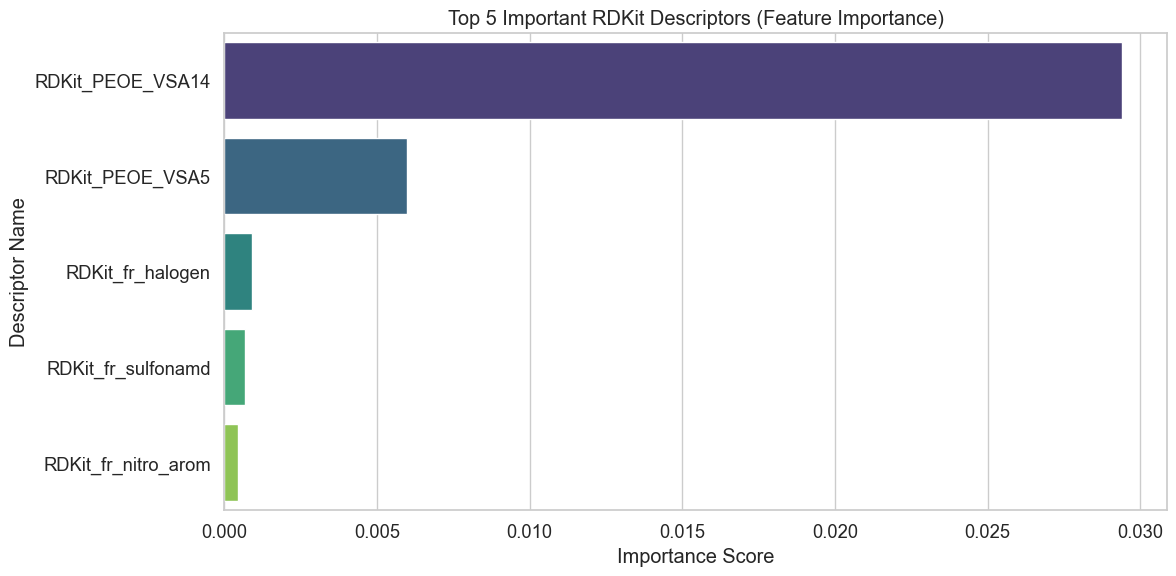

In [19]:
# Visualize the final result
selected_importance = rdkit_best_model.feature_importances_[selected_rdkit]  
selected_names = [rdkit_feat_names[i] for i in selected_rdkit]
rdkit_importance_df = pd.DataFrame({
    "Feature": selected_names,
    "Importance": selected_importance
}).sort_values("Importance", ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    hue="Feature",
    data=rdkit_importance_df,
    palette="viridis",
    orient="h",
    legend=False
)
plt.title("Top 5 Important RDKit Descriptors (Feature Importance)")
plt.xlabel("Importance Score")
plt.ylabel("Descriptor Name")
plt.tight_layout()
plt.show()